### Helper Functions

In [111]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

In [112]:
def blg(mid_prices, window_size = 20):
    cum_sum = np.cumsum(mid_prices)
    window_sum = cum_sum[window_size:] - cum_sum[:-window_size]
    window_avg = window_sum / window_size
    cum_sum_sq = np.cumsum(np.square(mid_prices))
    window_sum_sq = cum_sum_sq[window_size:] - cum_sum_sq[:-window_size]
    window_avg_sq = window_sum_sq / window_size

    window_variance = window_avg_sq - np.square(window_avg)
    window_std = np.sqrt(window_variance)
    return window_avg, window_std

In [113]:
import csv
import os

def process_log_file(filename):
    """
    Reads a log file and extracts the contents after "activities log:" into a CSV file with the same name.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
        print(f"finished reading {filename}")

    # Find the index of the line that says "activities log:"
    activities_index = -1
    for i, line in enumerate(lines):
        if line.startswith("Activities log:"):
            activities_index = i
            break

    # If "activities log:" is not found, return
    if activities_index == -1:
        return

    # Extract the lines after "activities log:"
    activities_lines = lines[activities_index + 1:]

    # Remove any leading or trailing whitespace from each line
    activities_lines = [line.strip() for line in activities_lines]

    csv_filename = f"{filename.split('.log')[0]}.csv"
    
    if os.path.exists(csv_filename):
        print(f"Error: File '{csv_filename}' already exists.")
        return csv_filename

    # Write the contents to a CSV file with the same name as the log file
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows([line.split(',') for line in activities_lines])
        print(f"{csv_filename} created and written to.")
        return csv_filename

In [123]:
def plot(mid_prices, window_size, n, length, log_file_path, product_df, pos):
    avg, std = blg(mid_prices[:length], window_size)
    x = np.array(range(window_size,length))
    y = mid_prices[window_size:length]

    fig, axes = plt.subplots(3,1,figsize=(20, 12),sharex=True)
    fig.suptitle(f"{log_file_path.split('/')[-1]}")
    fig.set_tight_layout(True)
    fig.set_facecolor('white')

    upper = avg + n * std
    lower = avg - n * std
    axes[0].plot(x, y, label="mid price", marker='o', markersize=4)
    axes[0].set_ylabel("mid price")
    axes[0].plot(x, avg[:length], label="moving average")
    axes[0].fill_between(x, upper[:length], lower[:length], alpha=0.1)
    axes[0].scatter(x[y>upper],y[y>upper], marker='o',color='red', s=8000/length,zorder=2)
    axes[0].scatter(x[y<lower],y[y<lower], marker='o',color='red', s=8000/length,zorder=2)

    axes[0].legend(loc='upper left')

    axes[1].plot(x, product_df["profit_and_loss"][window_size:length])
    axes[1].set_ylabel("profit")

    axes[2].plot(x, pos[window_size:length])
    axes[2].set_ylabel("position")
    axes[2].set_ybound(-20,20)

    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.set_xticks(np.linspace(0,length,41))

    plt.subplots_adjust(hspace=0)
    plt.show()

### Plot From CSVs

In [120]:
log_file_path = "logs/banana_mm_window_margin=2_limit=3_n=1p5.log"
# product = "PINA_COLADAS"
# product = "PEARLS"
product = "BANANAS"

csv_path = process_log_file(log_file_path)
# csv_path = "data/island-data-bottle-round-2/prices_round_2_day_0.csv"

df = pd.read_csv(csv_path, delimiter=";")
product_df = df.loc[df["product"]==product]
mid_prices = np.array(product_df["mid_price"])

with open(log_file_path, "r") as f:
    log_file = f.read()

log_profits = re.findall(r"if it is last round, profit = (-?\d+(?:\.\d+)?)", log_file)
positions = re.findall(rf"{product}'s position = (-?\d+)", log_file)
positions = [0] * (len(mid_prices)-len(positions)) + positions
pos = [float(num) for num in positions]

finished reading logs/banana_mm_window_margin=2_limit=3_n=1p5.log
logs/banana_mm_window_margin=2_limit=3_n=1p5.csv created and written to.


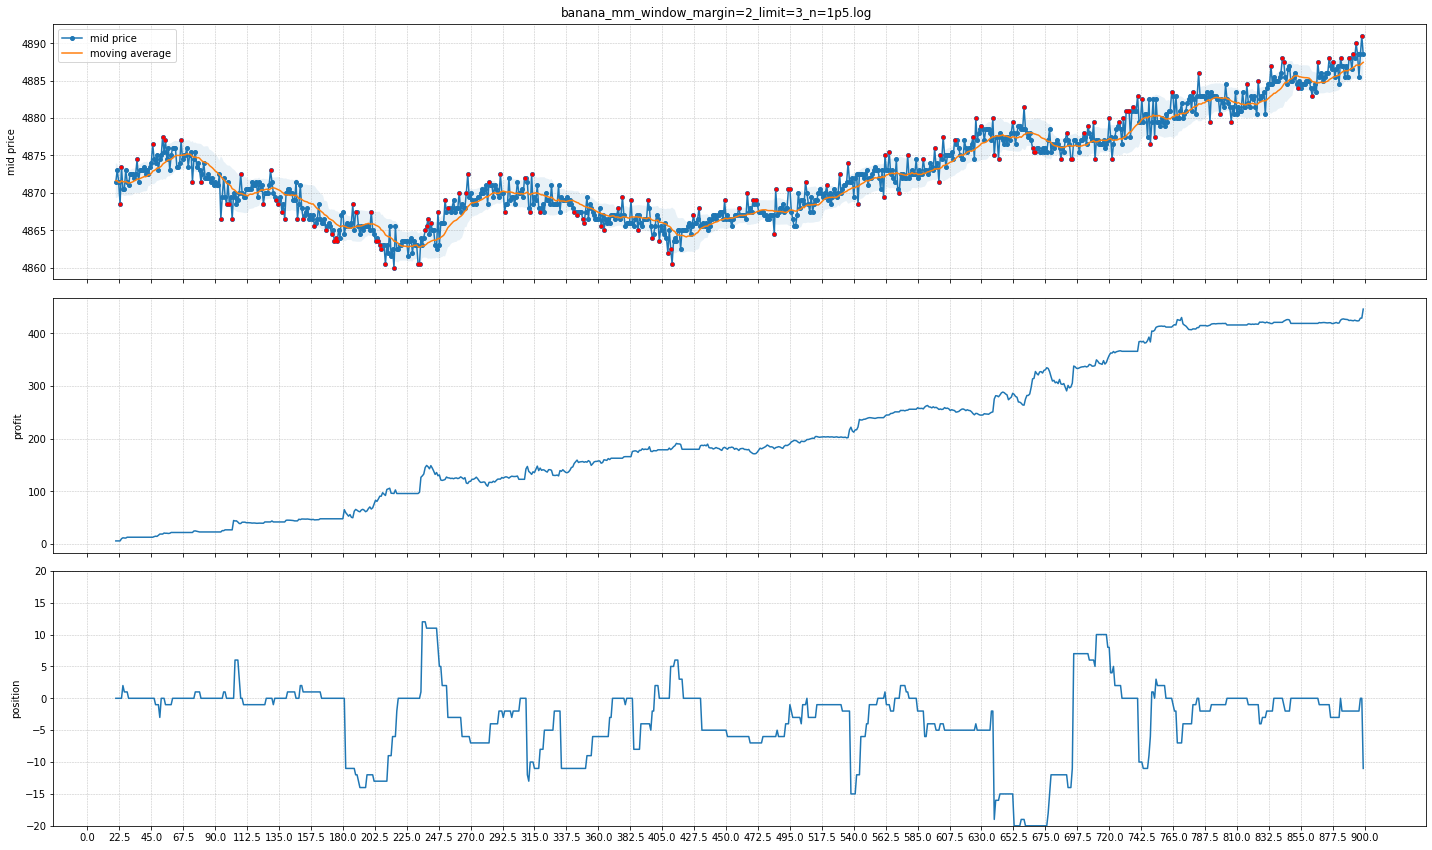

In [126]:
length = 900
window_size = 20
plot(mid_prices, window_size, 1.5, length, log_file_path, product_df, pos)

Observations:
- coconuts doesn't go back to moving average after "spikes" outside of the region

### Parse and Plot Profits From Log

In [117]:
log_file_path = "logs/final_final.log"

with open(log_file_path, "r") as f:
    log_file = f.read()

log_profits = re.findall(r"if it is last round, profit = (-?\d+(?:\.\d+)?)", log_file)
positions = re.findall(r"position now is {'BANANAS': (-?\d+(?:\.\d+)?)", log_file)
positions = [0] * (len(log_profits)-len(positions)) + positions

FileNotFoundError: [Errno 2] No such file or directory: 'logs/final_final.log'

In [ ]:
length = 500
position_limit = 20
x = range(length)
y = [float(num) for num in log_profits]
pos = [float(num) for num in positions]

fig, (ax1,ax2, ax3) = plt.subplots(3,1,figsize=(20, 9),sharex=True)

ax1.plot(x, y[:length])
ax1.set_ylabel("Profits")

ax2.plot(x, pos[:length])
ax2.set_ylabel("Positions")
ax2.set_ybound(-position_limit,position_limit)

plt.show()